In [1]:
import requests # library for making HTTP requests
import pandas as pd # library for data analysis
import datetime as dt # library for handling date and time objects
import matplotlib.pyplot as plt # library for creating plots

path_to_images = '/Users/rasmusklitteandersen/Library/CloudStorage/GoogleDrive-rasmusklitteandersen@gmail.com/Mit drev/speciale/images/'
root_path = '/Users/rasmusklitteandersen/Library/CloudStorage/GoogleDrive-rasmusklitteandersen@gmail.com/Mit drev/speciale/'
data_path = f'{root_path}data/final_dataset.csv'
model_path = f'{root_path}models/'
path_to_images = f'{root_path}images/'
base_log_dir = f'{model_path}logs/'
base_tuning_dir = f'{model_path}tuning/'
results_dir = f'{root_path}results/'
tables_dir = f'{root_path}tables/'

# Specify the desired start and end time
start_time = pd.Timestamp(2019, 10, 31)
end_time = pd.Timestamp(2024, 7, 2)

# Investigate data
Here, I investigate the data to find a representative weather station

In [2]:
api_key = 'd2820bde-4ad2-43f8-9299-83edf2c3d392' # insert your own key between the '' signs
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
r = requests.get(DMI_URL, params={'api-key': api_key}) # Issues a HTTP GET request



# Specify one or more station IDs or all_stations
stationId = '06109' #'06072' #Ødum
stationIds = [stationId]  

#Silstrup 06019: Har det hele, men ligger i vestjylland
#Isenvad 06068: Har det hele og ligger centralt

# Specify one or more parameter IDs or all_parameters
parameterIds = ['temp_mean_past1h', 'precip_past1h'] # 'radia_glob_past1h', 'wind_speed_past1h',', 'sun_last1h_glob'

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs, dfi = [], []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            
            # Drop other columns
            dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
            
            # Rename columns, e.g., 'properties.stationId' becomes 'stationId'
            dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
            
            # Drop identical rows (considers both value and time stamp)
            dfi = dfi[~dfi.duplicated()]
            dfi = dfi.set_index(['time','stationId','parameterId'])
            dfi = dfi['value'].unstack(['stationId','parameterId'])
            dfs.append(dfi)

data_dmi = pd.concat(dfs, axis='columns').sort_index()
print(data_dmi)

stationId                            06109              
parameterId               temp_mean_past1h precip_past1h
time                                                    
2019-10-31 00:00:00+00:00              4.2           0.0
2019-10-31 01:00:00+00:00              4.5           0.0
2019-10-31 02:00:00+00:00              4.6           0.0
2019-10-31 03:00:00+00:00              4.2           0.0
2019-10-31 04:00:00+00:00              4.2           0.0
...                                    ...           ...
2024-07-01 20:00:00+00:00             14.0           0.0
2024-07-01 21:00:00+00:00             13.3           0.0
2024-07-01 22:00:00+00:00             13.0           0.0
2024-07-01 23:00:00+00:00             12.6           0.0
2024-07-02 00:00:00+00:00             12.2           0.0

[40572 rows x 2 columns]


In [3]:
#stationIds = ['06052', '06132']

data_dmi_filter = data_dmi.copy()
data_dmi_filter = data_dmi_filter[stationIds]
data_dmi_filter.columns = data_dmi_filter.columns.droplevel(0)

# Convert the 'time' column timezone without setting it to None explicitly, assuming 'time' is the index or a column after reset_index()
data_dmi_filter['time'] = data_dmi_filter.index #['time'].dt.tz_localize(None)
data_dmi_filter['time'] = data_dmi_filter['time'].dt.tz_localize(None)
data_dmi_filter = data_dmi_filter.set_index('time')
print(data_dmi_filter)


parameterId          temp_mean_past1h  precip_past1h
time                                                
2019-10-31 00:00:00               4.2            0.0
2019-10-31 01:00:00               4.5            0.0
2019-10-31 02:00:00               4.6            0.0
2019-10-31 03:00:00               4.2            0.0
2019-10-31 04:00:00               4.2            0.0
...                               ...            ...
2024-07-01 20:00:00              14.0            0.0
2024-07-01 21:00:00              13.3            0.0
2024-07-01 22:00:00              13.0            0.0
2024-07-01 23:00:00              12.6            0.0
2024-07-02 00:00:00              12.2            0.0

[40572 rows x 2 columns]


In [4]:
start_date = start_time.strftime('%Y-%m-%d') #2015-01-01'
end_date = end_time.strftime('%Y-%m-%d') #'2022-06-01'

price_area  = '{"PriceArea":["DK1"]}'
url = f'https://api.energidataservice.dk/dataset/Elspotprices?start={start_date}&end={end_date}&filter={price_area}'
response = requests.get(
    url=f'https://api.energidataservice.dk/dataset/Elspotprices?start={start_date}&end={end_date}&filter={price_area}')

if response.ok:  # More idiomatic way to check for a successful request
    records = response.json().get('records', [])
    # Directly filtering necessary columns and renaming them
    data_el_spot_DK1 = (pd.json_normalize(records)
                          .loc[:, ['HourUTC', 'SpotPriceDKK']]
                          .rename(columns={'HourUTC': 'time', 'SpotPriceDKK': 'SpotPriceDK1'}))

    # Convert 'time' column to datetime without timezone information
    data_el_spot_DK1['time'] = pd.to_datetime(data_el_spot_DK1['time']).dt.tz_localize(None)

    # Display the first few rows of the processed DataFrame
    print(data_el_spot_DK1)
else:
    print(f"Failed to fetch data: {response.status_code}")

                     time  SpotPriceDK1
0     2024-07-01 21:00:00    653.700012
1     2024-07-01 20:00:00    782.580017
2     2024-07-01 19:00:00    939.719971
3     2024-07-01 18:00:00    791.080017
4     2024-07-01 17:00:00    733.729980
...                   ...           ...
40938 2019-10-31 03:00:00    252.949997
40939 2019-10-31 02:00:00    247.720001
40940 2019-10-31 01:00:00    253.550003
40941 2019-10-31 00:00:00    261.320007
40942 2019-10-30 23:00:00    270.429993

[40943 rows x 2 columns]


In [5]:
price_area  = '{"PriceArea":["DK2"]}'

response = requests.get(
    url=f'https://api.energidataservice.dk/dataset/Elspotprices?start={start_date}&end={end_date}&filter={price_area}')

if response.ok:  # More idiomatic way to check for a successful request
    records = response.json().get('records', [])
    # Directly filtering necessary columns and renaming them
    data_el_spot_DK2 = (pd.json_normalize(records)
                          .loc[:, ['HourUTC', 'SpotPriceDKK']]
                          .rename(columns={'HourUTC': 'time', 'SpotPriceDKK': 'SpotPriceDK2'}))

    # Convert 'time' column to datetime without timezone information
    data_el_spot_DK2['time'] = pd.to_datetime(data_el_spot_DK2['time']).dt.tz_localize(None)

    # Display the first few rows of the processed DataFrame
    print(data_el_spot_DK2)
else:
    print(f"Failed to fetch data: {response.status_code}")

                     time  SpotPriceDK2
0     2024-07-01 21:00:00    653.700012
1     2024-07-01 20:00:00    782.580017
2     2024-07-01 19:00:00    939.719971
3     2024-07-01 18:00:00   1214.109985
4     2024-07-01 17:00:00    745.890015
...                   ...           ...
40938 2019-10-31 03:00:00    260.350006
40939 2019-10-31 02:00:00    247.720001
40940 2019-10-31 01:00:00    253.550003
40941 2019-10-31 00:00:00    261.320007
40942 2019-10-30 23:00:00    270.429993

[40943 rows x 2 columns]


In [6]:
import requests
import pandas as pd

# Definer variable for start, slut, og prisområde
price_area = "DK1"

# Sammensæt URL med de angivne parametre
url = f"https://api.energidataservice.dk/dataset/Forecasts_Hour?offset=0&start={start_date}&end={end_date}&filter=%7B%22PriceArea%22:%5B%22{price_area}%22%5D%7D&sort=HourUTC%20ASC"

# Send an HTTP GET request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response data from JSON format to a Python dictionary
    data = response.json()

    # Load data into a pandas DataFrame assuming 'records' is the key containing the actual data
    if 'records' in data:
        df = pd.DataFrame(data['records'])

        # Pivot the DataFrame to have columns for each forecast type with corresponding values
        df_pivoted = df.pivot(index='HourUTC', columns='ForecastType', values='ForecastDayAhead')

        print("Data loaded and pivoted into DataFrame successfully:")
        print(df_pivoted.head(20))  # Display the first few rows of the pivoted DataFrame
    else:
        print("No 'records' key in JSON response")
else:
    print("Failed to retrieve data. Status code:", response.status_code)


Data loaded and pivoted into DataFrame successfully:
ForecastType         Offshore Wind  Onshore Wind  Solar
HourUTC                                                
2019-10-31T10:00:00            NaN           NaN    NaN
2019-10-31T11:00:00            NaN           NaN    NaN
2019-10-31T12:00:00            NaN           NaN    NaN
2019-10-31T13:00:00            NaN           NaN    NaN
2019-10-31T14:00:00            NaN           NaN    NaN
2019-10-31T15:00:00            NaN           NaN    NaN
2019-10-31T16:00:00            NaN           NaN    NaN
2019-10-31T17:00:00            NaN           NaN    NaN
2019-10-31T18:00:00            NaN           NaN    NaN
2019-10-31T19:00:00            NaN           NaN    NaN
2019-10-31T20:00:00            NaN           NaN    NaN
2019-10-31T21:00:00            NaN           NaN    NaN
2019-10-31T22:00:00            NaN           NaN    NaN
2019-10-31T23:00:00     394.458344    386.375000    0.0
2019-11-01T00:00:00     419.166656    399.833344   

In [7]:
forecast_weather = df_pivoted.copy().reset_index().rename(columns={'HourUTC': 'time'})
forecast_weather['time'] = pd.to_datetime(forecast_weather['time']).dt.tz_localize(None)
merged_elspot_weather_forecast = pd.merge(data_el_spot_DK1, forecast_weather, on='time', how='left').set_index('time').interpolate(method='time')
print(merged_elspot_weather_forecast)

                     SpotPriceDK1  Offshore Wind  Onshore Wind       Solar
time                                                                      
2024-07-01 21:00:00    653.700012     592.583313    932.666687    0.004583
2024-07-01 20:00:00    782.580017     562.708313    928.583313    0.880833
2024-07-01 19:00:00    939.719971     568.541687    952.208313   23.168751
2024-07-01 18:00:00    791.080017     589.083313   1008.041687  123.207085
2024-07-01 17:00:00    733.729980     593.375000   1095.416626  282.817902
...                           ...            ...           ...         ...
2019-10-31 03:00:00    252.949997     394.458344    386.375000    0.000000
2019-10-31 02:00:00    247.720001     394.458344    386.375000    0.000000
2019-10-31 01:00:00    253.550003     394.458344    386.375000    0.000000
2019-10-31 00:00:00    261.320007     394.458344    386.375000    0.000000
2019-10-30 23:00:00    270.429993     394.458344    386.375000    0.000000

[40943 rows x 4 columns]

In [8]:
nan_values = merged_elspot_weather_forecast[merged_elspot_weather_forecast.isna()]

# For at se rækkerne, hvor der findes NaN-værdier, kan du gøre følgende
rows_with_nans = merged_elspot_weather_forecast[merged_elspot_weather_forecast.isna().any(axis=1)]

# Vis de fundne rækker med NaN-værdier
print(rows_with_nans)

Empty DataFrame
Columns: [SpotPriceDK1, Offshore Wind, Onshore Wind, Solar]
Index: []


In [9]:
data_el_spot_DK1['time'] = pd.to_datetime(data_el_spot_DK1.loc[:,'time'])
data_el_spot_DK2['time'] = pd.to_datetime(data_el_spot_DK2.loc[:,'time'])

merged_elspot = pd.merge(data_el_spot_DK1, data_el_spot_DK2, on='time', how='inner').set_index('time')
print(merged_elspot)

                     SpotPriceDK1  SpotPriceDK2
time                                           
2024-07-01 21:00:00    653.700012    653.700012
2024-07-01 20:00:00    782.580017    782.580017
2024-07-01 19:00:00    939.719971    939.719971
2024-07-01 18:00:00    791.080017   1214.109985
2024-07-01 17:00:00    733.729980    745.890015
...                           ...           ...
2019-10-31 03:00:00    252.949997    260.350006
2019-10-31 02:00:00    247.720001    247.720001
2019-10-31 01:00:00    253.550003    253.550003
2019-10-31 00:00:00    261.320007    261.320007
2019-10-30 23:00:00    270.429993    270.429993

[40943 rows x 2 columns]


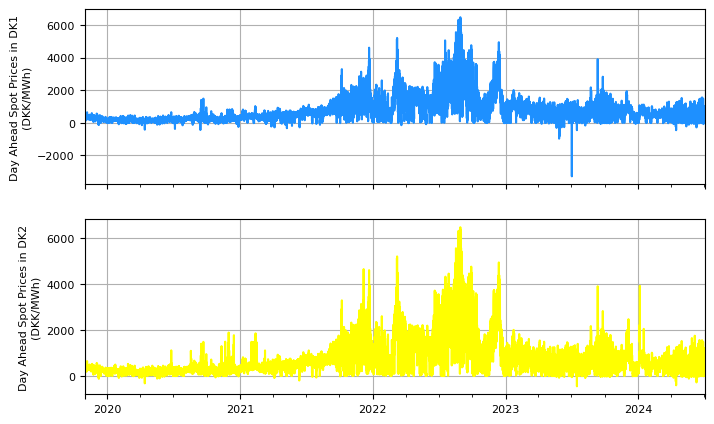

In [28]:
import matplotlib.pyplot as plt

colors = ['#1E90FF', 'yellow']

# Assuming 'merged_elspot' is your DataFrame and 'path_to_images' is defined
ax = merged_elspot[['SpotPriceDK1', 'SpotPriceDK2']].plot(
    figsize=(8, 5), 
    legend=False, 
    fontsize=8, 
    rot=0, 
    subplots=True,
    color=colors,
    grid=True,
    xlabel=''   # List of colors for each line
    )

# Setting labels for each subplot
ax[0].set_ylabel('Day Ahead Spot Prices in DK1\n(DKK/MWh)', fontsize=8)
ax[1].set_ylabel('Day Ahead Spot Prices in DK2\n(DKK/MWh)', fontsize=8)  # Label for the second subplot

# Save the plot to a file
plt.savefig(f"{path_to_images}elspot_prices.png", dpi=150)

# Show the plot
plt.show()


In [10]:
merged_data = pd.merge(merged_elspot_weather_forecast.reset_index(), data_dmi_filter, on='time', how='right') \
                .set_index('time') 
print(merged_data)

                     SpotPriceDK1  Offshore Wind  Onshore Wind     Solar  \
time                                                                       
2019-10-31 00:00:00    261.320007     394.458344    386.375000  0.000000   
2019-10-31 01:00:00    253.550003     394.458344    386.375000  0.000000   
2019-10-31 02:00:00    247.720001     394.458344    386.375000  0.000000   
2019-10-31 03:00:00    252.949997     394.458344    386.375000  0.000000   
2019-10-31 04:00:00    267.739990     394.458344    386.375000  0.000000   
...                           ...            ...           ...       ...   
2024-07-01 20:00:00    782.580017     562.708313    928.583313  0.880833   
2024-07-01 21:00:00    653.700012     592.583313    932.666687  0.004583   
2024-07-01 22:00:00           NaN            NaN           NaN       NaN   
2024-07-01 23:00:00           NaN            NaN           NaN       NaN   
2024-07-02 00:00:00           NaN            NaN           NaN       NaN   

           

In [11]:
#merged_data = merged_data.dropna()
merged_data.to_csv('data/elspot_and_weather_data_hourly.csv', index=True)

In [12]:
daily_data = merged_data.resample('D').mean() 
daily_data.to_csv('data/elspot_and_weather_data_daily.csv', index=True)

In [13]:
df_water = pd.read_excel('data/hydro_reservoir_data.xlsx') #.set_index('Uge')

# Start by melting the original DataFrame
df_long = pd.melt(df_water, id_vars=['Uge'], var_name='Year', value_name='hydro_reservoir')

# Directly convert 'Year' and 'Uge' to a datetime format representing Monday of each week
# This combines the conversion to string, zero-padding, and datetime conversion in one step
df_long['time'] = pd.to_datetime(df_long['Year'].astype(str) + 'W' + df_long['Uge'].astype(str).str.zfill(2) + '-1', format='%GW%V-%u')

# Sort, drop unnecessary columns, and set 'Date' as index in one chained command
df_water_final = df_long.sort_values(by='time', ascending=True).drop(columns=['Uge', 'Year']).dropna()
print(df_water_final)

     hydro_reservoir       time
477         0.759061 2014-12-29
478         0.740539 2015-01-05
479         0.722027 2015-01-12
480         0.689552 2015-01-19
481         0.658803 2015-01-26
..               ...        ...
30          0.770000 2024-07-29
31          0.787000 2024-08-05
32          0.789000 2024-08-12
33          0.813000 2024-08-19
34          0.829000 2024-08-26

[505 rows x 2 columns]


In [14]:
# Determine the number of hours in a week
hours_in_week = 7 * 24

# Create a new DataFrame to hold the hourly data
# This involves repeating each weekly row 168 times (for each hour of the week)
# and then dividing the 'Level' by 168 to distribute it evenly
hourly_water_data = df_water_final.reindex(df_water_final.index.repeat(hours_in_week))

# Assuming 'Level' is the column with weekly data to be distributed
#hourly_water_data['hydro_reservoir'] /= hours_in_week
hourly_water_data = hourly_water_data.set_index('time')

# Generate an hourly time range that matches the length of the new DataFrame
hourly_range = pd.date_range(start=hourly_water_data.index[0], periods=len(hourly_water_data), freq='h')

# Assign this hourly range as the new index
hourly_water_data['time'] = hourly_range #.sort_index(descending=True)
hourly_water_data = hourly_water_data.reset_index(drop=True).sort_values(by='time', ascending=True)
print(hourly_water_data)

#hourly_water_data['time'] = pd.to_datetime(df_water_final['time'])


       hydro_reservoir                time
0             0.759061 2014-12-29 00:00:00
1             0.759061 2014-12-29 01:00:00
2             0.759061 2014-12-29 02:00:00
3             0.759061 2014-12-29 03:00:00
4             0.759061 2014-12-29 04:00:00
...                ...                 ...
84835         0.829000 2024-09-01 19:00:00
84836         0.829000 2024-09-01 20:00:00
84837         0.829000 2024-09-01 21:00:00
84838         0.829000 2024-09-01 22:00:00
84839         0.829000 2024-09-01 23:00:00

[84840 rows x 2 columns]


In [15]:
merged_data_updated = pd.merge(merged_data, hourly_water_data, on = 'time', how = 'left')

# Reverses order of index to get earliest date first
merged_data_updated = merged_data_updated.iloc[::-1].reset_index(drop=False)
merged_data_updated = merged_data_updated.set_index('time').drop(columns=['index']).interpolate(method='time').dropna()
print(merged_data_updated)

                     SpotPriceDK1  Offshore Wind  Onshore Wind       Solar  \
time                                                                         
2024-07-01 21:00:00    653.700012     592.583313    932.666687    0.004583   
2024-07-01 20:00:00    782.580017     562.708313    928.583313    0.880833   
2024-07-01 19:00:00    939.719971     568.541687    952.208313   23.168751   
2024-07-01 18:00:00    791.080017     589.083313   1008.041687  123.207085   
2024-07-01 17:00:00    733.729980     593.375000   1095.416626  282.817902   
...                           ...            ...           ...         ...   
2019-10-31 04:00:00    267.739990     394.458344    386.375000    0.000000   
2019-10-31 03:00:00    252.949997     394.458344    386.375000    0.000000   
2019-10-31 02:00:00    247.720001     394.458344    386.375000    0.000000   
2019-10-31 01:00:00    253.550003     394.458344    386.375000    0.000000   
2019-10-31 00:00:00    261.320007     394.458344    386.375000  

In [ ]:
#hourly_water_data.set_index('time', inplace=True)  # Setting time as index if not already set

plot = pd.DataFrame(merged_data_updated['hydro_reservoir'])

# Creating a figure with dynamic subplots based on the number of columns
fig, axes = plt.subplots(nrows=len(plot.columns), ncols=1, figsize=(12, 5 * len(plot.columns)), sharex=True)

# Check if there's only one column and ensure 'axes' is iterable
if plot.columns.size == 1:
    axes = [axes]  # Make a list of axes if only one plot

# Loop through each column and create a bar plot on its respective subplot
for ax, column in zip(axes, plot.columns):
    ax.bar(plot.index, plot[column], width=0.8, label=column, color='skyblue')  # Adjust width as necessary
    ax.set_title(column)
    ax.set_ylabel('Values')
    ax.grid(True)
    ax.legend(loc='upper right')

# Formatting the x-axis to handle date labels better
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.tight_layout()
plt.show()

## Importing Carbon, Coal and Natural Gas prices

In [16]:
import pandas as pd

df_carbon = pd.read_csv('data/European Union Allowance (EUA) Yearly Futures Historical Data.csv', usecols=['Date', 'Price']).dropna()
df_carbon.rename(columns={'Price': 'carbon_price', 'Date': 'time'}, inplace=True)
df_carbon['time'] = pd.to_datetime(df_carbon['time'])
df_carbon.set_index('time', inplace=True)

# Load and prepare coal data
df_coal = pd.read_csv('data/Coal_09_06_24-12_10_18.csv', usecols=['Date', 'Close']).dropna()
df_coal.rename(columns={'Close': 'coal_price', 'Date': 'time'}, inplace=True)
df_coal['time'] = pd.to_datetime(df_coal['time'])
df_coal.set_index('time', inplace=True)

# Load and prepare natural gas data
df_natural_gas = pd.read_csv('data/Natural Gas (Henry Hub)_09_06_24-12_10_18.csv', usecols=['Date', 'Close']).dropna()
df_natural_gas.rename(columns={'Close': 'natural_gas_price', 'Date': 'time'}, inplace=True)
df_natural_gas['time'] = pd.to_datetime(df_natural_gas['time'])
df_natural_gas.set_index('time', inplace=True)

# Merge all datasets
df_commodity_merged = pd.merge(df_coal, df_carbon, left_index=True, right_index=True, how='right')
df_commodity_merged = pd.merge(df_commodity_merged, df_natural_gas, left_index=True, right_index=True, how='left')


/var/folders/2s/vzpsd8c17tx0pd2fs7c080pr0000gn/T/ipykernel_16511/2198582584.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_coal['time'] = pd.to_datetime(df_coal['time'])
/var/folders/2s/vzpsd8c17tx0pd2fs7c080pr0000gn/T/ipykernel_16511/2198582584.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_natural_gas['time'] = pd.to_datetime(df_natural_gas['time'])


## Interpolation

In [17]:
df = pd.DataFrame(df_commodity_merged)

# Upsample to hourly data, using forward fill to carry the last valid observation forward
df_hourly = df.resample('h').ffill()

# Now df_hourly contains the upsampled data, but it's constant throughout each day.
# To create a linear transition between days, use .interpolate()
df_commodity_merged_final = df_hourly.interpolate(method='time')
print(df_commodity_merged_final)
#df_carbon_final = df_hourly.drop('date', axis=1)

                     coal_price  carbon_price  natural_gas_price
time                                                            
2018-12-03 00:00:00         NaN         20.63                NaN
2018-12-03 01:00:00         NaN         20.63                NaN
2018-12-03 02:00:00         NaN         20.63                NaN
2018-12-03 03:00:00         NaN         20.63                NaN
2018-12-03 04:00:00         NaN         20.63                NaN
...                         ...           ...                ...
2024-09-05 20:00:00      114.00         66.20              2.254
2024-09-05 21:00:00      114.00         66.20              2.254
2024-09-05 22:00:00      114.00         66.20              2.254
2024-09-05 23:00:00      114.00         66.20              2.254
2024-09-06 00:00:00      114.75         66.50              2.275

[50497 rows x 3 columns]


In [18]:
merged_data_full = pd.merge(merged_data_updated, df_commodity_merged_final, on = 'time', how = 'left')
print(merged_data_full)

                     SpotPriceDK1  Offshore Wind  Onshore Wind       Solar  \
time                                                                         
2024-07-01 21:00:00    653.700012     592.583313    932.666687    0.004583   
2024-07-01 20:00:00    782.580017     562.708313    928.583313    0.880833   
2024-07-01 19:00:00    939.719971     568.541687    952.208313   23.168751   
2024-07-01 18:00:00    791.080017     589.083313   1008.041687  123.207085   
2024-07-01 17:00:00    733.729980     593.375000   1095.416626  282.817902   
...                           ...            ...           ...         ...   
2019-10-31 04:00:00    267.739990     394.458344    386.375000    0.000000   
2019-10-31 03:00:00    252.949997     394.458344    386.375000    0.000000   
2019-10-31 02:00:00    247.720001     394.458344    386.375000    0.000000   
2019-10-31 01:00:00    253.550003     394.458344    386.375000    0.000000   
2019-10-31 00:00:00    261.320007     394.458344    386.375000  

# Illustrate data 

In [19]:
merged_data_full_inter = merged_data_full.interpolate(method='time')

merged_data_full_inter.to_csv('data/el_weather_hydro_coal_carbon_data.csv', index=True)
print(merged_data_full_inter)

                     SpotPriceDK1  Offshore Wind  Onshore Wind       Solar  \
time                                                                         
2024-07-01 21:00:00    653.700012     592.583313    932.666687    0.004583   
2024-07-01 20:00:00    782.580017     562.708313    928.583313    0.880833   
2024-07-01 19:00:00    939.719971     568.541687    952.208313   23.168751   
2024-07-01 18:00:00    791.080017     589.083313   1008.041687  123.207085   
2024-07-01 17:00:00    733.729980     593.375000   1095.416626  282.817902   
...                           ...            ...           ...         ...   
2019-10-31 04:00:00    267.739990     394.458344    386.375000    0.000000   
2019-10-31 03:00:00    252.949997     394.458344    386.375000    0.000000   
2019-10-31 02:00:00    247.720001     394.458344    386.375000    0.000000   
2019-10-31 01:00:00    253.550003     394.458344    386.375000    0.000000   
2019-10-31 00:00:00    261.320007     394.458344    386.375000  

In [20]:
import matplotlib.dates as mdates

names = {
    'SpotPriceDK1': ['Day Ahead Spot Price', '#1E90FF'],
    'Offshore Wind': ['Offshore Wind', 'skyblue'],
    'Onshore Wind': ['Onshore Wind', 'aquamarine'],
    'Solar': ['Solar', 'yellow'],
    'precip_past1h': ['Precipitation', 'lightskyblue'],
    'temp_mean_past1h': ['Temperature', 'red'],
    'hydro_reservoir': ['Hydro Reservoir Levels', 'skyblue'],
    'carbon_price': ['CO2 Price (Index)', 'lightgreen'],
    'coal_price': ['Coal Price', '#696969'],
    'natural_gas_price': ['Natural Gas Price', 'yellowgreen']
}

params_to_plot = list(names.keys())
end_time_plot = end_time

# Ensuring the 'time' column is a datetime object
data_to_plot = merged_data_full_inter.reset_index() #.interpolate(method='time')
data_to_plot['time'] = pd.to_datetime(data_to_plot['time'])
data_to_plot = data_to_plot[data_to_plot['time'] <= end_time_plot]

# Create a complete datetime index from min to max time, with a specified frequency if necessary
full_time_index = pd.date_range(start=data_to_plot['time'].min(), end=end_time_plot, freq='h')  # Adjust the frequency 'H' as needed

# Reindex the DataFrame to this full index
data_to_plot.set_index('time', inplace=True)
data_to_plot = data_to_plot.reindex(full_time_index).interpolate(method='time')
#final_dataset = data_to_plot.copy()

# Create a figure with dynamic subplots based on the number of parameters
fig, axes = plt.subplots(len(params_to_plot), 1, figsize=(12, 2 * len(params_to_plot)), sharex=True)

# If there's only one parameter, `axes` won't be a list, so we need to make it iterable
if len(params_to_plot) == 1:
    axes = [axes]

# Loop through each parameter and corresponding axis
for i, par in enumerate(params_to_plot):
    
    if par in ['Onshore Wind', 'Offshore Wind', 'Solar', 'precip', 'temp_mean', 'hydro_reservoir']:
        axes[i].bar(data_to_plot.index, data_to_plot[par], color=names[par][1])
    else:
        axes[i].plot(data_to_plot.index, data_to_plot[par], color=names[par][1])
    
    axes[i].set_ylabel(names[par][0])
    axes[i].tick_params(axis='y')
    axes[i].grid(True)

# Set x-axis limits explicitly using pd.Timestamp on the last subplot
axes[-1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time_plot))

# Use YearLocator and DateFormatter to format the x-axis on the last subplot
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-ticks for better readability on the last subplot
plt.savefig(f"{path_to_images}wheater_variables_and_hydro_coal_carbon_final_with_bars.png", dpi=150)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

NameError: name 'mdates' is not defined

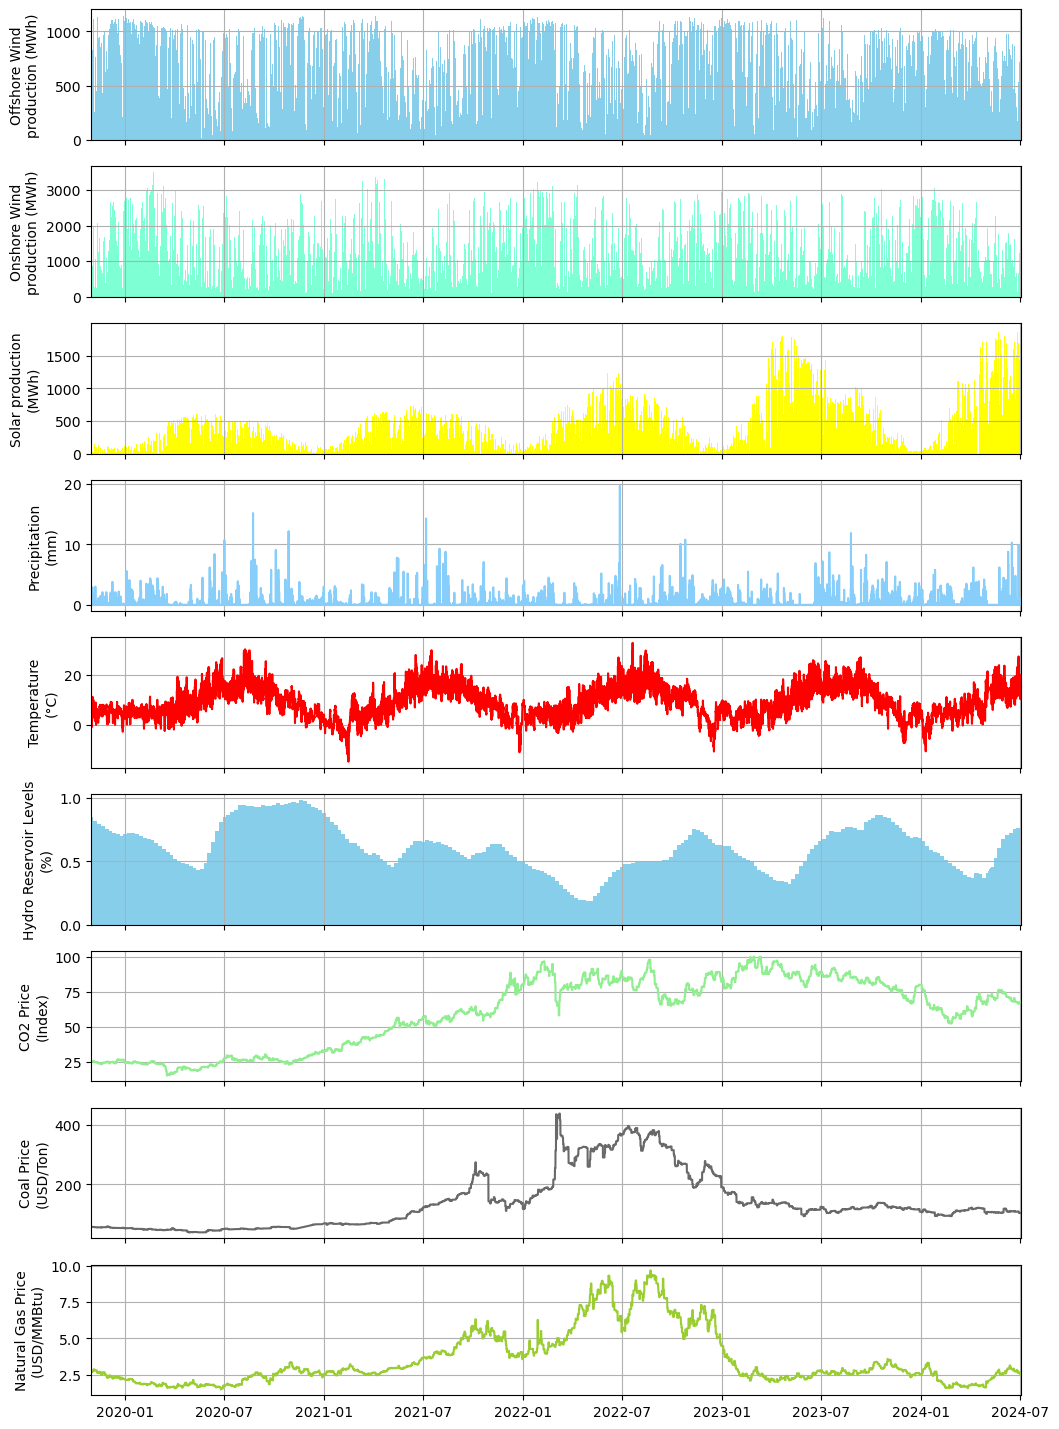

In [26]:
import mdates

names = {
    #'SpotPriceDK1': ['Day Ahead Spot Price', '#1E90FF'],
    'Offshore Wind': ['Offshore Wind\nproduction (MWh)', 'skyblue'],
    'Onshore Wind': ['Onshore Wind\nproduction (MWh)', 'aquamarine'],
    'Solar': ['Solar production\n(MWh)', 'yellow'],
    'precip_past1h': ['Precipitation\n(mm)', 'lightskyblue'],
    'temp_mean_past1h': ['Temperature\n(°C)', 'red'],
    'hydro_reservoir': ['Hydro Reservoir Levels\n(%)', 'skyblue'],
    'carbon_price': ['CO2 Price\n(Index)', 'lightgreen'],
    'coal_price': ['Coal Price\n(USD/Ton)', '#696969'],
    'natural_gas_price': ['Natural Gas Price\n(USD/MMBtu)', 'yellowgreen']
}

params_to_plot = list(names.keys())
end_time_plot = end_time

# Ensuring the 'time' column is a datetime object
data_to_plot = merged_data_full_inter.reset_index() #.interpolate(method='time')
data_to_plot['time'] = pd.to_datetime(data_to_plot['time'])
data_to_plot = data_to_plot[data_to_plot['time'] <= end_time_plot]

# Create a complete datetime index from min to max time, with a specified frequency if necessary
full_time_index = pd.date_range(start=data_to_plot['time'].min(), end=end_time_plot, freq='h')  # Adjust the frequency 'H' as needed

# Reindex the DataFrame to this full index
data_to_plot.set_index('time', inplace=True)
data_to_plot = data_to_plot.reindex(full_time_index).interpolate(method='time')
#final_dataset = data_to_plot.copy()

# Create a figure with dynamic subplots based on the number of parameters
fig, axes = plt.subplots(len(params_to_plot), 1, figsize=(12, 2 * len(params_to_plot)), sharex=True)

# If there's only one parameter, `axes` won't be a list, so we need to make it iterable
if len(params_to_plot) == 1:
    axes = [axes]

# Loop through each parameter and corresponding axis
for i, par in enumerate(params_to_plot):
    
    if par in ['Onshore Wind', 'Offshore Wind', 'Solar', 'precip', 'temp_mean', 'hydro_reservoir']:
        axes[i].bar(data_to_plot.index, data_to_plot[par], color=names[par][1])
    else:
        axes[i].plot(data_to_plot.index, data_to_plot[par], color=names[par][1])
    
    axes[i].set_ylabel(names[par][0])
    axes[i].tick_params(axis='y')
    axes[i].grid(True)

# Set x-axis limits explicitly using pd.Timestamp on the last subplot
axes[-1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time_plot))

# Use YearLocator and DateFormatter to format the x-axis on the last subplot
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-ticks for better readability on the last subplot
plt.savefig(f"{path_to_images}exogenous_variables.png", dpi=150)
plt.tight_layout()
plt.show()

In [21]:
names = {
    #'SpotPriceDK1': ['Day Ahead Spot Price', '#1E90FF'],
    'Offshore Wind': ['Offshore Wind\nproduction (MWh)', 'skyblue'],
    'Onshore Wind': ['Onshore Wind\nproduction (MWh)', 'aquamarine'],
    'Solar': ['Solar production\n(MWh)', 'yellow'],
    'precip_past1h': ['Precipitation\n(mm)', 'lightskyblue'],
    'temp_mean_past1h': ['Temperature\n(°C)', 'red'],
    'hydro_reservoir': ['Hydro Reservoir Levels\n(%)', 'skyblue'],
    'carbon_price': ['CO2 Price\n(Index)', 'lightgreen'],
    'coal_price': ['Coal Price\n(USD/Ton)', '#696969'],
    'natural_gas_price': ['Natural Gas Price\n(USD/MMBtu)', 'yellowgreen']
}

params_to_plot = list(names.keys())
end_time_plot = end_time

# Ensuring the 'time' column is a datetime object
data_to_plot = merged_data_full_inter.reset_index() #.interpolate(method='time')
data_to_plot['time'] = pd.to_datetime(data_to_plot['time'])
data_to_plot = data_to_plot[data_to_plot['time'] <= end_time_plot]

# Create a complete datetime index from min to max time, with a specified frequency if necessary
full_time_index = pd.date_range(start=data_to_plot['time'].min(), end=end_time_plot, freq='h')  # Adjust the frequency 'H' as needed

# Reindex the DataFrame to this full index
data_to_plot.set_index('time', inplace=True)
data_to_plot = data_to_plot.reindex(full_time_index).interpolate(method='time')
#final_dataset = data_to_plot.copy()


names = {
    'SpotPriceDK1': ['Day Ahead Spot Price', '#1E90FF'],
    'Offshore Wind': ['Offshore Wind', 'skyblue'],
    'Onshore Wind': ['Onshore Wind', 'aquamarine'],
    'Solar': ['Solar', 'yellow'],
    'precip_past1h': ['Precipitation', 'lightskyblue'],
    'temp_mean_past1h': ['Temperature', 'red'],
    'hydro_reservoir': ['Hydro Reservoir Levels', 'skyblue'],
    'carbon_price': ['CO2 Price', 'lightgreen'],
    'coal_price': ['Coal Price', '#696969'],
    'natural_gas_price': ['Natural Gas Price', 'yellowgreen']
}

# Rename the columns of final_dataset
final_dataset = data_to_plot.copy()

# Create a copy and rename the columns in one step
final_dataset = data_to_plot.rename(columns={old_name: new_name[0] for old_name, new_name in names.items()}).reset_index()

# Rename the 'index' column to 'time' directly while resetting the index
final_dataset.rename(columns={'index': 'time'}, inplace=True)

# Save the updated DataFrame to a CSV file
final_dataset.to_csv('data/dataset.csv', index=False)  # Use index=False since 'time' is now a column

# Print the first few rows to verify the changes
print(final_dataset.head())
print(final_dataset.index)

                 time  Day Ahead Spot Price  Offshore Wind  Onshore Wind  \
0 2019-10-31 00:00:00            261.320007     394.458344       386.375   
1 2019-10-31 01:00:00            253.550003     394.458344       386.375   
2 2019-10-31 02:00:00            247.720001     394.458344       386.375   
3 2019-10-31 03:00:00            252.949997     394.458344       386.375   
4 2019-10-31 04:00:00            267.739990     394.458344       386.375   

   Solar  Temperature  Precipitation  Hydro Reservoir Levels  Coal Price  \
0    0.0          4.2            0.0                0.847514        56.4   
1    0.0          4.5            0.0                0.847514        56.4   
2    0.0          4.6            0.0                0.847514        56.4   
3    0.0          4.2            0.0                0.847514        56.4   
4    0.0          4.2            0.0                0.847514        56.4   

   CO2 Price  Natural Gas Price  
0      25.61              2.633  
1      25.61      

# Dummies 

In [22]:
import pandas as pd

# Antager at 'final_dataset' er dit datasæt
df = pd.DataFrame(final_dataset)

# Kontrollerer kolonnerne i DataFrame


# Reset index
df.reset_index(inplace=True)

# Konverterer 'time' kolonnen til datetime (opdater navnet hvis nødvendigt)
df['time'] = pd.to_datetime(df['time'])  # Sørg for at 'time' er korrekt

# Opretter dummyvariabler for ugedage
df = pd.get_dummies(df, columns=['time'], drop_first=False)
print(df.head())


   index  Day Ahead Spot Price  Offshore Wind  Onshore Wind  Solar  \
0      0            261.320007     394.458344       386.375    0.0   
1      1            253.550003     394.458344       386.375    0.0   
2      2            247.720001     394.458344       386.375    0.0   
3      3            252.949997     394.458344       386.375    0.0   
4      4            267.739990     394.458344       386.375    0.0   

   Temperature  Precipitation  Hydro Reservoir Levels  Coal Price  CO2 Price  \
0          4.2            0.0                0.847514        56.4      25.61   
1          4.5            0.0                0.847514        56.4      25.61   
2          4.6            0.0                0.847514        56.4      25.61   
3          4.2            0.0                0.847514        56.4      25.61   
4          4.2            0.0                0.847514        56.4      25.61   

   ...  time_2024-07-01 15:00:00  time_2024-07-01 16:00:00  \
0  ...                     False    

In [23]:
import pandas as pd

# Antager, at 'final_dataset' er dit datasæt
df = pd.DataFrame(final_dataset.copy())

# Reset index
df.reset_index(inplace=True)

# Konverterer 'time' kolonnen til datetime (sørg for navnet er korrekt)
df['time'] = pd.to_datetime(df['time'])

# Opretter en ny kolonne for ugedagen
df['weekday'] = df['time'].dt.day_name()

# Oprettelse af dummyvariabler for hver dag i ugen
df = pd.get_dummies(df, columns=['weekday'], drop_first=False)

#df.set_index('time', inplace=True)
df.drop(columns=['index'], inplace=True)
# Viser resultatet
# Save the updated DataFrame to a CSV file
df.to_csv('data/dataset_with_dummies.csv', index=False) 
print(df.head())

                 time  Day Ahead Spot Price  Offshore Wind  Onshore Wind  \
0 2019-10-31 00:00:00            261.320007     394.458344       386.375   
1 2019-10-31 01:00:00            253.550003     394.458344       386.375   
2 2019-10-31 02:00:00            247.720001     394.458344       386.375   
3 2019-10-31 03:00:00            252.949997     394.458344       386.375   
4 2019-10-31 04:00:00            267.739990     394.458344       386.375   

   Solar  Temperature  Precipitation  Hydro Reservoir Levels  Coal Price  \
0    0.0          4.2            0.0                0.847514        56.4   
1    0.0          4.5            0.0                0.847514        56.4   
2    0.0          4.6            0.0                0.847514        56.4   
3    0.0          4.2            0.0                0.847514        56.4   
4    0.0          4.2            0.0                0.847514        56.4   

   CO2 Price  Natural Gas Price  weekday_Friday  weekday_Monday  \
0      25.61       

# Lags

In [24]:
df_lags = df.copy()

# Variables to lag by 24 hours
lags_names = [
    'Precipitation', 
    'Temperature',
    'Hydro Reservoir Levels',
    'CO2 Price',
    'Coal Price',
    'Natural Gas Price'
]

# Lag each specified column by one day and replace the original
for column in lags_names:
    df_lags[column] = df_lags[column].shift(24)

# Variables to lag specified hours
lags_names = [
    'Day Ahead Spot Price',
]

# Lag each specified column by one day
for column in lags_names:
    df_lags[column + '_lagged_1_hour'] = df_lags[column].shift(1)

# Lag each specified column by one day
for column in lags_names:
    df_lags[column + '_lagged_2_hour'] = df_lags[column].shift(2)


df_lags.dropna(inplace=True)

# Display the DataFrame with lagged variables
print(df_lags.head())

df_lags.to_csv('data/dataset_with_dummies_and_lags.csv', index=False)


                  time  Day Ahead Spot Price  Offshore Wind  Onshore Wind  \
24 2019-11-01 00:00:00            250.179993     419.166656    399.833344   
25 2019-11-01 01:00:00            216.559998     400.875000    391.708344   
26 2019-11-01 02:00:00            202.589996     402.000000    389.166656   
27 2019-11-01 03:00:00            195.500000     425.666656    430.791656   
28 2019-11-01 04:00:00            195.270004     501.333344    500.708344   

    Solar  Temperature  Precipitation  Hydro Reservoir Levels  Coal Price  \
24    0.0          4.2            0.0                0.847514        56.4   
25    0.0          4.5            0.0                0.847514        56.4   
26    0.0          4.6            0.0                0.847514        56.4   
27    0.0          4.2            0.0                0.847514        56.4   
28    0.0          4.2            0.0                0.847514        56.4   

    CO2 Price  Natural Gas Price  weekday_Friday  weekday_Monday  \
24    

In [25]:
df_lags = df_lags.copy()

# Variables to lag
lags_names = [
    'Day Ahead Spot Price',
]
df_lags = df.copy()

# Lag each specified column by one day
for column in lags_names:
    df_lags[column + '_lagged_24_hour'] = df_lags[column].shift(24)

# Lag each specified column by one day
for column in lags_names:
    df_lags[column + '_lagged_25_hour'] = df_lags[column].shift(25)

df_lags.dropna(inplace=True)
# Display the DataFrame with lagged variables
print(df_lags.head())

df_lags.to_csv('data/final_dataset_test.csv', index=False) 

                  time  Day Ahead Spot Price  Offshore Wind  Onshore Wind  \
25 2019-11-01 01:00:00            216.559998     400.875000    391.708344   
26 2019-11-01 02:00:00            202.589996     402.000000    389.166656   
27 2019-11-01 03:00:00            195.500000     425.666656    430.791656   
28 2019-11-01 04:00:00            195.270004     501.333344    500.708344   
29 2019-11-01 05:00:00            287.679993     598.750000    561.333313   

    Solar  Temperature  Precipitation  Hydro Reservoir Levels  Coal Price  \
25    0.0         -0.1            0.0                0.847514       56.95   
26    0.0         -0.8            0.0                0.847514       56.95   
27    0.0         -1.0            0.0                0.847514       56.95   
28    0.0         -1.1            0.0                0.847514       56.95   
29    0.0         -1.1            0.0                0.847514       56.95   

    CO2 Price  Natural Gas Price  weekday_Friday  weekday_Monday  \
25    